---
## 📋 Section 1: Environment Setup

In [2]:
import os
import sys
from pathlib import Path
import pickle

# Get project root
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
print(f"📁 Project Root: {project_root}")

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("✅ Environment ready!")

📁 Project Root: d:\Projects\AI-Music-DeepFake-Detector
✅ Environment ready!


In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import warnings
from tqdm.auto import tqdm
import json

# Audio processing
import librosa
import librosa.display
import soundfile as sf

# Deep Learning
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ All libraries imported!")

✅ All libraries imported!


In [14]:
# Load configuration
config_path = project_root / 'config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Set paths
raw_real_dir = project_root / 'data' / 'raw' / 'real'
raw_synthetic_dir = project_root / 'data' / 'raw' / 'synthetic'
processed_dir = project_root / 'data' / 'processed'
splits_dir = project_root / 'data' / 'splits'

# Create directories
processed_dir.mkdir(parents=True, exist_ok=True)
splits_dir.mkdir(parents=True, exist_ok=True)

# GPU check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")

print("\n✅ Configuration loaded!")
print(f"   Sample Rate: {config['audio']['sample_rate']} Hz")
print(f"   Duration: {config['audio']['duration']} seconds")
print(f"   Mel Bins: {config['audio']['n_mels']}")

🖥️  Device: cuda

✅ Configuration loaded!
   Sample Rate: 22050 Hz
   Duration: 10 seconds
   Mel Bins: 128


---
## 📂 Section 2: Load Dataset Metadata

In [5]:
# Collect all audio files
real_files = list(raw_real_dir.glob('*.wav')) + list(raw_real_dir.glob('*.mp3'))
synthetic_files = list(raw_synthetic_dir.glob('*.wav')) + list(raw_synthetic_dir.glob('*.mp3'))

# Filter out files in subdirectories (like archive)
real_files = [f for f in real_files if f.parent == raw_real_dir]
synthetic_files = [f for f in synthetic_files if f.parent == raw_synthetic_dir]

print(f"📊 Dataset Summary:")
print(f"   Real music files: {len(real_files)}")
print(f"   Synthetic music files: {len(synthetic_files)}")
print(f"   Total files: {len(real_files) + len(synthetic_files)}")

# Create dataframe with metadata
data = []
for file_path in real_files:
    data.append({'path': str(file_path), 'label': 0, 'class': 'real'})
for file_path in synthetic_files:
    data.append({'path': str(file_path), 'label': 1, 'class': 'synthetic'})

df = pd.DataFrame(data)
print(f"\n✅ Created metadata dataframe with {len(df)} samples")
print(f"\n{df['class'].value_counts()}")

📊 Dataset Summary:
   Real music files: 1000
   Synthetic music files: 256
   Total files: 1256

✅ Created metadata dataframe with 1256 samples

class
real         1000
synthetic     256
Name: count, dtype: int64


---
## 🎵 Section 3: Audio Preprocessing Functions

In [6]:
def load_and_preprocess_audio(file_path, config):
    """
    Load audio file and preprocess to fixed length
    
    Args:
        file_path: Path to audio file
        config: Configuration dictionary
    
    Returns:
        audio: Preprocessed audio array
        sr: Sample rate
    """
    sr = config['audio']['sample_rate']
    duration = config['audio']['duration']
    target_length = sr * duration
    
    try:
        # Load audio
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
        
        # Pad or trim to exact length
        if len(audio) < target_length:
            # Pad with zeros
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            # Trim to target length
            audio = audio[:target_length]
        
        # Normalize to [-1, 1]
        if np.abs(audio).max() > 0:
            audio = audio / np.abs(audio).max()
        
        return audio, sr
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None


def extract_mel_spectrogram(audio, sr, config):
    """
    Extract mel-spectrogram from audio
    
    Args:
        audio: Audio array
        sr: Sample rate
        config: Configuration dictionary
    
    Returns:
        mel_spec_db: Mel-spectrogram in dB scale
    """
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=config['audio']['n_fft'],
        hop_length=config['audio']['hop_length'],
        n_mels=config['audio']['n_mels'],
        fmin=config['audio']['fmin'],
        fmax=config['audio']['fmax']
    )
    
    # Convert to dB scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    return mel_spec_db


def extract_additional_features(audio, sr, config):
    """
    Extract additional audio features
    
    Returns:
        features: Dictionary of features
    """
    features = {}
    
    # Spectral features
    features['spectral_centroid'] = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    features['spectral_rolloff'] = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    features['spectral_bandwidth'] = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
    features['zero_crossing_rate'] = librosa.feature.zero_crossing_rate(audio)[0]
    features['rms_energy'] = librosa.feature.rms(y=audio)[0]
    
    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=config['audio']['n_mfcc'])
    features['mfccs'] = mfccs
    
    return features


print("✅ Preprocessing functions defined!")

✅ Preprocessing functions defined!


---
## 🔄 Section 4: Data Augmentation

In [7]:
def add_noise(audio, noise_factor=0.005):
    """Add random noise to audio"""
    noise = np.random.randn(len(audio))
    augmented = audio + noise_factor * noise
    return augmented


def time_shift(audio, shift_max=0.2):
    """Shift audio in time"""
    shift = np.random.randint(int(len(audio) * -shift_max), int(len(audio) * shift_max))
    return np.roll(audio, shift)


def pitch_shift(audio, sr, n_steps=2):
    """Shift pitch of audio"""
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)


def time_stretch(audio, rate=1.1):
    """Time stretch audio"""
    return librosa.effects.time_stretch(audio, rate=rate)


def augment_audio(audio, sr, augmentation_type='random'):
    """
    Apply random augmentation to audio
    
    Args:
        audio: Audio array
        sr: Sample rate
        augmentation_type: Type of augmentation or 'random'
    
    Returns:
        augmented: Augmented audio
    """
    if augmentation_type == 'random':
        augmentation_type = np.random.choice(['noise', 'time_shift', 'pitch', 'stretch', 'none'])
    
    if augmentation_type == 'noise':
        return add_noise(audio)
    elif augmentation_type == 'time_shift':
        return time_shift(audio)
    elif augmentation_type == 'pitch':
        steps = np.random.choice([-2, -1, 1, 2])
        return pitch_shift(audio, sr, steps)
    elif augmentation_type == 'stretch':
        rate = np.random.choice([0.9, 1.1])
        stretched = time_stretch(audio, rate)
        # Ensure same length
        if len(stretched) > len(audio):
            return stretched[:len(audio)]
        else:
            return np.pad(stretched, (0, len(audio) - len(stretched)), mode='constant')
    else:
        return audio


print("✅ Augmentation functions defined!")

✅ Augmentation functions defined!


---
## 🎯 Section 5: Process All Audio Files

🔍 Testing preprocessing on sample files...

✅ Processed real sample: blues.00000.wav
   Audio shape: (220500,)
   Mel-spectrogram shape: (128, 431)

✅ Processed synthetic sample: suno_ai_0000.mp3
   Audio shape: (220500,)
   Mel-spectrogram shape: (128, 431)


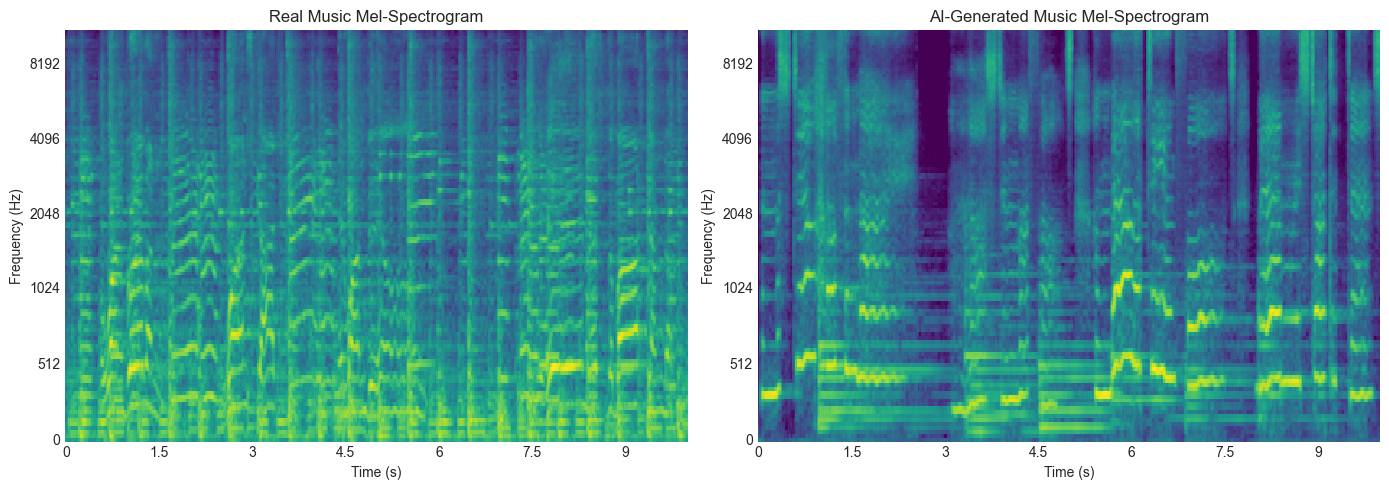


✅ Preprocessing test complete!


In [8]:
# Test preprocessing on a few samples
print("🔍 Testing preprocessing on sample files...\n")

# Test real sample
test_real = real_files[0]
audio, sr = load_and_preprocess_audio(test_real, config)
mel_spec = extract_mel_spectrogram(audio, sr, config)

print(f"✅ Processed real sample: {test_real.name}")
print(f"   Audio shape: {audio.shape}")
print(f"   Mel-spectrogram shape: {mel_spec.shape}")

# Test synthetic sample
test_synthetic = synthetic_files[0]
audio, sr = load_and_preprocess_audio(test_synthetic, config)
mel_spec = extract_mel_spectrogram(audio, sr, config)

print(f"\n✅ Processed synthetic sample: {test_synthetic.name}")
print(f"   Audio shape: {audio.shape}")
print(f"   Mel-spectrogram shape: {mel_spec.shape}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Load and process both samples for comparison
audio_real, _ = load_and_preprocess_audio(test_real, config)
audio_synth, _ = load_and_preprocess_audio(test_synthetic, config)
mel_real = extract_mel_spectrogram(audio_real, sr, config)
mel_synth = extract_mel_spectrogram(audio_synth, sr, config)

librosa.display.specshow(mel_real, sr=sr, hop_length=config['audio']['hop_length'],
                         x_axis='time', y_axis='mel', ax=axes[0], cmap='viridis')
axes[0].set_title('Real Music Mel-Spectrogram')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Frequency (Hz)')

librosa.display.specshow(mel_synth, sr=sr, hop_length=config['audio']['hop_length'],
                         x_axis='time', y_axis='mel', ax=axes[1], cmap='viridis')
axes[1].set_title('AI-Generated Music Mel-Spectrogram')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

print("\n✅ Preprocessing test complete!")

In [9]:
# Process all files and save mel-spectrograms
print("🔄 Processing all audio files...")
print(f"   This may take 10-20 minutes for {len(df)} files\n")

processed_data = []
failed_files = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing audio"):
    try:
        # Load and preprocess
        audio, sr = load_and_preprocess_audio(row['path'], config)
        
        if audio is None:
            failed_files.append(row['path'])
            continue
        
        # Extract mel-spectrogram
        mel_spec = extract_mel_spectrogram(audio, sr, config)
        
        # Extract additional features
        features = extract_additional_features(audio, sr, config)
        
        # Store processed data
        processed_data.append({
            'file_path': row['path'],
            'label': row['label'],
            'class': row['class'],
            'mel_spectrogram': mel_spec,
            'mfccs': features['mfccs'],
            'spectral_centroid_mean': features['spectral_centroid'].mean(),
            'spectral_rolloff_mean': features['spectral_rolloff'].mean(),
            'spectral_bandwidth_mean': features['spectral_bandwidth'].mean(),
            'zero_crossing_rate_mean': features['zero_crossing_rate'].mean(),
            'rms_energy_mean': features['rms_energy'].mean()
        })
    
    except Exception as e:
        print(f"\nError processing {row['path']}: {e}")
        failed_files.append(row['path'])
        continue

print(f"\n✅ Processed {len(processed_data)} files successfully")
if failed_files:
    print(f"⚠️  Failed to process {len(failed_files)} files")

🔄 Processing all audio files...
   This may take 10-20 minutes for 1256 files



Processing audio:   0%|          | 0/1256 [00:00<?, ?it/s]

Error loading d:\Projects\AI-Music-DeepFake-Detector\data\raw\real\jazz.00054.wav: 

✅ Processed 1255 files successfully
⚠️  Failed to process 1 files


---
## 📊 Section 6: Create Train/Val/Test Splits

In [18]:
# Create dataframe from processed data
processed_df = pd.DataFrame(processed_data)

print(f"📊 Processed Dataset Summary:")
print(f"   Total samples: {len(processed_df)}")
print(f"\nClass distribution:")
print(processed_df['class'].value_counts())

# Balance dataset: use 200 samples from each class
print(f"\n⚖️ Balancing dataset to 200 samples per class...")
real_df = processed_df[processed_df['label'] == 0].sample(n=200, random_state=42)
synthetic_df = processed_df[processed_df['label'] == 1].sample(n=200, random_state=42)
balanced_df = pd.concat([real_df, synthetic_df], ignore_index=True).sample(frac=1, random_state=42)

print(f"   Balanced dataset: {len(balanced_df)} samples")
print(f"\nBalanced class distribution:")
print(balanced_df['class'].value_counts())

# Split ratios from config
train_ratio = config['dataset']['train_split']
val_ratio = config['dataset']['val_split']
test_ratio = config['dataset']['test_split']

print(f"\n📐 Split ratios: Train={train_ratio}, Val={val_ratio}, Test={test_ratio}")

# First split: train+val vs test
train_val_df, test_df = train_test_split(
    balanced_df,
    test_size=test_ratio,
    random_state=42,
    stratify=balanced_df['label']
)

# Second split: train vs val
val_size = val_ratio / (train_ratio + val_ratio)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_size,
    random_state=42,
    stratify=train_val_df['label']
)

print(f"\n✅ Dataset splits created:")
print(f"   Train: {len(train_df)} samples ({len(train_df)/len(balanced_df)*100:.1f}%)")
print(f"   Val:   {len(val_df)} samples ({len(val_df)/len(balanced_df)*100:.1f}%)")
print(f"   Test:  {len(test_df)} samples ({len(test_df)/len(balanced_df)*100:.1f}%)")

# Verify class balance
print(f"\n📊 Class distribution:")
print(f"\nTrain set:")
print(train_df['class'].value_counts())
print(f"\nVal set:")
print(val_df['class'].value_counts())
print(f"\nTest set:")
print(test_df['class'].value_counts())

📊 Processed Dataset Summary:
   Total samples: 1255

Class distribution:
class
real         999
synthetic    256
Name: count, dtype: int64

⚖️ Balancing dataset to 200 samples per class...
   Balanced dataset: 400 samples

Balanced class distribution:
class
synthetic    200
real         200
Name: count, dtype: int64

📐 Split ratios: Train=0.7, Val=0.15, Test=0.15

✅ Dataset splits created:
   Train: 279 samples (69.8%)
   Val:   61 samples (15.2%)
   Test:  60 samples (15.0%)

📊 Class distribution:

Train set:
class
synthetic    140
real         139
Name: count, dtype: int64

Val set:
class
real         31
synthetic    30
Name: count, dtype: int64

Test set:
class
synthetic    30
real         30
Name: count, dtype: int64


---
## 💾 Section 7: Save Processed Data

In [19]:
# Save processed data
print("💾 Saving processed data...\n")

# Save train set
train_file = processed_dir / 'train_data.pkl'
with open(train_file, 'wb') as f:
    pickle.dump(train_df.to_dict('records'), f)
print(f"✅ Saved train data: {train_file}")

# Save validation set
val_file = processed_dir / 'val_data.pkl'
with open(val_file, 'wb') as f:
    pickle.dump(val_df.to_dict('records'), f)
print(f"✅ Saved validation data: {val_file}")

# Save test set
test_file = processed_dir / 'test_data.pkl'
with open(test_file, 'wb') as f:
    pickle.dump(test_df.to_dict('records'), f)
print(f"✅ Saved test data: {test_file}")

# Save metadata
metadata = {
    'total_samples': len(processed_df),
    'train_samples': len(train_df),
    'val_samples': len(val_df),
    'test_samples': len(test_df),
    'real_samples': len(processed_df[processed_df['label'] == 0]),
    'synthetic_samples': len(processed_df[processed_df['label'] == 1]),
    'mel_spec_shape': processed_df.iloc[0]['mel_spectrogram'].shape,
    'sample_rate': config['audio']['sample_rate'],
    'duration': config['audio']['duration'],
    'n_mels': config['audio']['n_mels'],
    'failed_files': failed_files
}

metadata_file = processed_dir / 'metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
print(f"✅ Saved metadata: {metadata_file}")

# Calculate and display sizes
total_size = sum(f.stat().st_size for f in [train_file, val_file, test_file]) / (1024**2)
print(f"\n📊 Total processed data size: {total_size:.2f} MB")

💾 Saving processed data...

✅ Saved train data: d:\Projects\AI-Music-DeepFake-Detector\data\processed\train_data.pkl
✅ Saved validation data: d:\Projects\AI-Music-DeepFake-Detector\data\processed\val_data.pkl
✅ Saved test data: d:\Projects\AI-Music-DeepFake-Detector\data\processed\test_data.pkl
✅ Saved metadata: d:\Projects\AI-Music-DeepFake-Detector\data\processed\metadata.json

📊 Total processed data size: 97.42 MB


---
## 📈 Section 8: Feature Analysis & Visualization

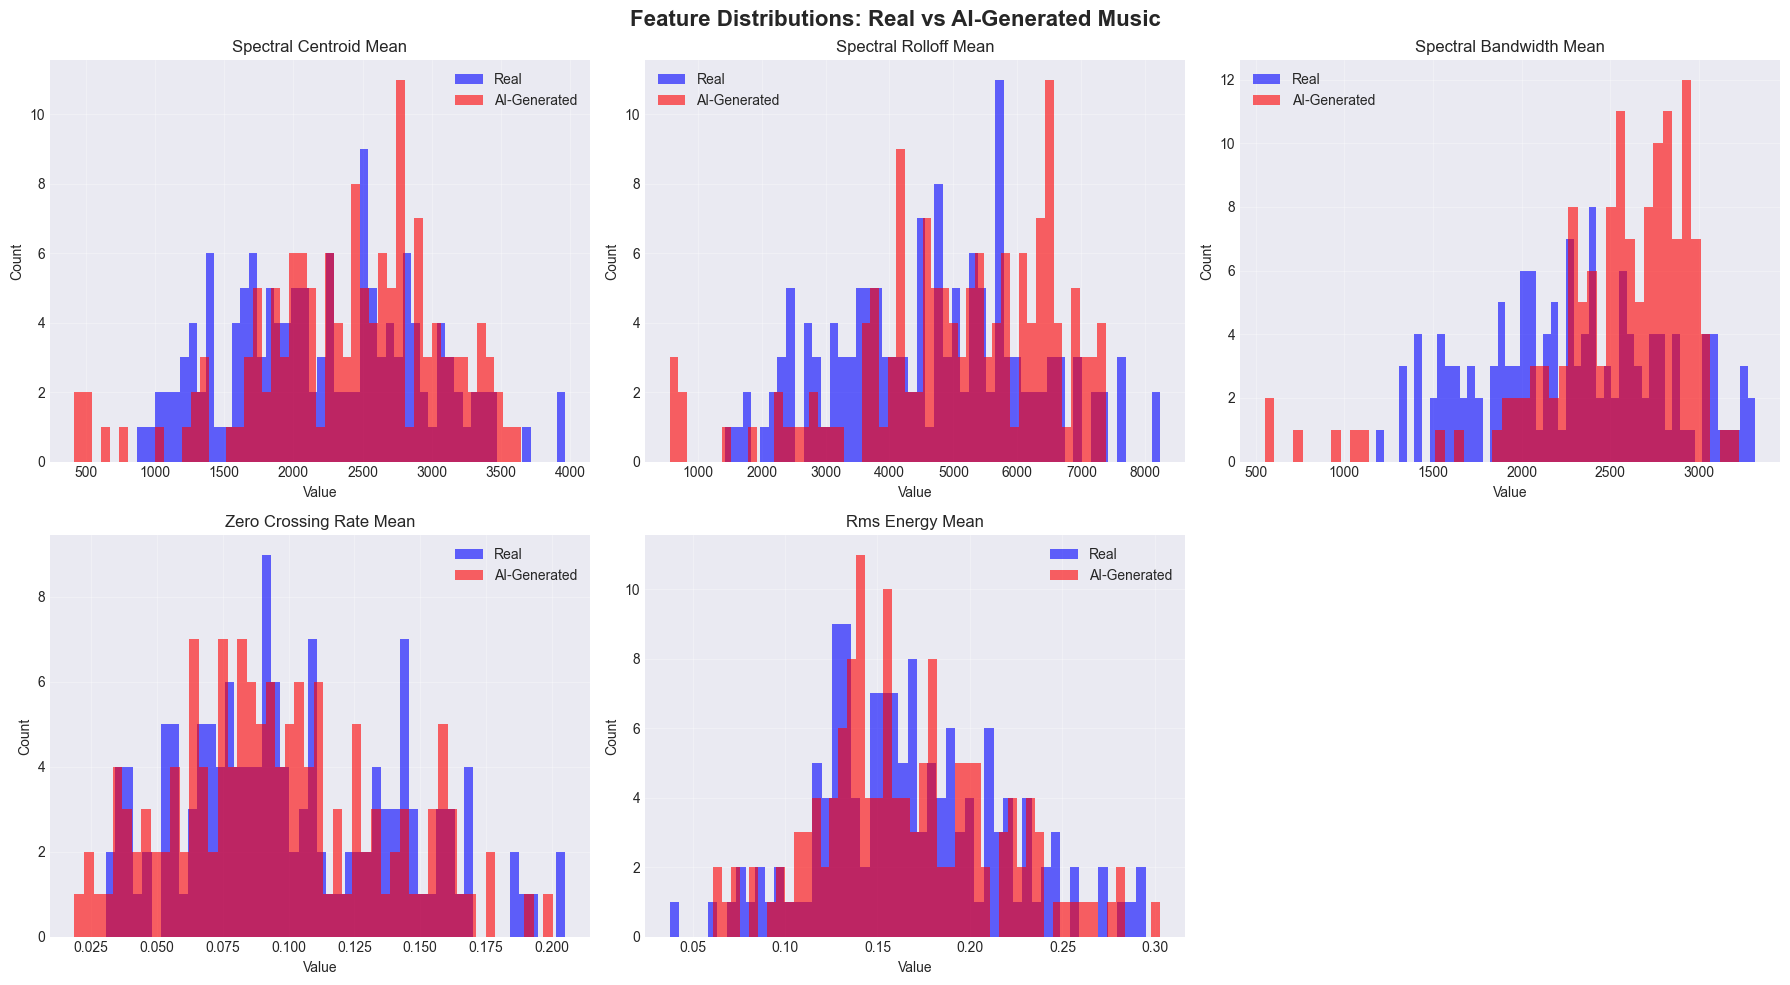

✅ Feature analysis complete!


In [20]:
# Analyze feature distributions
feature_cols = ['spectral_centroid_mean', 'spectral_rolloff_mean', 
                'spectral_bandwidth_mean', 'zero_crossing_rate_mean', 'rms_energy_mean']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(feature_cols):
    # Plot distributions for real vs synthetic
    real_data = train_df[train_df['label'] == 0][feature]
    synth_data = train_df[train_df['label'] == 1][feature]
    
    axes[idx].hist(real_data, bins=50, alpha=0.6, label='Real', color='blue')
    axes[idx].hist(synth_data, bins=50, alpha=0.6, label='AI-Generated', color='red')
    axes[idx].set_title(f'{feature.replace("_", " ").title()}')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Count')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Hide extra subplot
axes[-1].axis('off')

plt.suptitle('Feature Distributions: Real vs AI-Generated Music', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Feature analysis complete!")

In [21]:
# Statistical comparison
comparison_stats = []

for feature in feature_cols:
    real_mean = train_df[train_df['label'] == 0][feature].mean()
    synth_mean = train_df[train_df['label'] == 1][feature].mean()
    real_std = train_df[train_df['label'] == 0][feature].std()
    synth_std = train_df[train_df['label'] == 1][feature].std()
    diff_pct = ((synth_mean - real_mean) / real_mean) * 100
    
    comparison_stats.append({
        'Feature': feature.replace('_mean', '').replace('_', ' ').title(),
        'Real Mean': f"{real_mean:.4f}",
        'Real Std': f"{real_std:.4f}",
        'Synthetic Mean': f"{synth_mean:.4f}",
        'Synthetic Std': f"{synth_std:.4f}",
        'Diff %': f"{diff_pct:+.2f}%"
    })

stats_df = pd.DataFrame(comparison_stats)

print("\n📊 FEATURE STATISTICS COMPARISON")
print("="*100)
print(stats_df.to_string(index=False))
print("="*100)


📊 FEATURE STATISTICS COMPARISON
           Feature Real Mean  Real Std Synthetic Mean Synthetic Std  Diff %
 Spectral Centroid 2215.4186  689.8066      2392.3310      687.5765  +7.99%
  Spectral Rolloff 4657.2630 1530.4370      5062.0899     1558.4278  +8.69%
Spectral Bandwidth 2283.9904  516.3883      2516.1954      479.7028 +10.17%
Zero Crossing Rate    0.1017    0.0415         0.0961        0.0396  -5.50%
        Rms Energy    0.1678    0.0503         0.1662        0.0486  -0.91%


---
## ✅ Section 9: Summary & Next Steps

In [22]:
print("\n" + "="*70)
print("🎉 NOTEBOOK 02 COMPLETED SUCCESSFULLY!")
print("="*70)

print("\n📝 Summary:")
print(f"   ✅ Processed {len(processed_df)} audio files")
print(f"   ✅ Extracted mel-spectrograms (shape: {processed_df.iloc[0]['mel_spectrogram'].shape})")
print(f"   ✅ Extracted MFCCs and spectral features")
print(f"   ✅ Created train/val/test splits")
print(f"      - Train: {len(train_df)} samples")
print(f"      - Val: {len(val_df)} samples")
print(f"      - Test: {len(test_df)} samples")
print(f"   ✅ Saved processed data ({total_size:.2f} MB)")
print(f"   ✅ Analyzed feature distributions")

if failed_files:
    print(f"\n⚠️  Warning: {len(failed_files)} files failed to process")

print("\n🚀 Next: Notebook 03 - Model Development (Autoencoder + Transformer)")
print("="*70)


🎉 NOTEBOOK 02 COMPLETED SUCCESSFULLY!

📝 Summary:
   ✅ Processed 1255 audio files
   ✅ Extracted mel-spectrograms (shape: (128, 431))
   ✅ Extracted MFCCs and spectral features
   ✅ Created train/val/test splits
      - Train: 279 samples
      - Val: 61 samples
      - Test: 60 samples
   ✅ Saved processed data (97.42 MB)
   ✅ Analyzed feature distributions

⚠️  Warning: 1 files failed to process

🚀 Next: Notebook 03 - Model Development (Autoencoder + Transformer)
